In [1]:
import numpy as np
import pickle

In [2]:
BOARD_ROWS = 3
BOARD_COLS = 3

In [3]:
class State:
    def __init__(self, p1, p2):
        self.board = np.zeros((BOARD_ROWS, BOARD_COLS))
        self.p1 = p1
        self.p2 = p2
        self.isEnd = False
        self.boardHash = None
        self.playerSymbol = 1
        
    def getHash(self):
        self.boardHash = str(self.board.reshape(BOARD_COLS * BOARD_ROWS))
        return self.boardHash
    
    def winner(self):
        for i in range(BOARD_ROWS):
            if sum(self.board[i, :]) == 3:
                self.isEnd = True
                return 1
            if sum(self.board[i, :]) == -3:
                self.isEnd = True
                return -1
        for i in range(BOARD_COLS):
            if sum(self.board[:, i]) == 3:
                self.isEnd = True
                return 1
            if sum(self.board[:, i]) == -3:
                self.isEnd = True
                return -1
        diag_sum1 = sum([self.board[i, i] for i in range(BOARD_COLS)])
        diag_sum2 = sum([self.board[i, BOARD_COLS - i - 1] for i in range(BOARD_COLS)])
        diag_sum = max(abs(diag_sum1), abs(diag_sum2))
        if diag_sum == 3:
            self.isEnd = True
            if diag_sum1 == 3 or diag_sum2 == 3:
                return 1
            else:
                return -1
        if len(self.availablePositions()) == 0:
            self.isEnd = True
            return 0
        self.isEnd = False
        return None
    
    def availablePositions(self):
        positions = []
        for i in range(BOARD_ROWS):
            for j in range(BOARD_COLS):
                if self.board[i, j] == 0:
                    positions.append((i, j))
        return positions
    
    def updateState(self, position):
        self.board[position] = self.playerSymbol
        self.playerSymbol = -1 if self.playerSymbol == 1 else 1
        
    def giveReward(self):
        result = self.winner()
        if result == 1:
            self.p1.feedReward(1)
            self.p2.feedReward(0)
        elif result == -1:
            self.p1.feedReward(0)
            self.p2.feedReward(1)
        else:
            self.p1.feedReward(0.1)
            self.p2.feedReward(0.5)
            
    def reset(self):
        self.board = np.zeros((BOARD_ROWS, BOARD_COLS))
        self.boardHash = None
        self.isEnd = False
        self.playerSymbol = 1
        
    def play(self, rounds=100):
        for i in range(rounds):
            if i % 1000 == 0:
                print("Rounds {}".format(i))
            while not self.isEnd:
                positions = self.availablePositions()
                p1_action = self.p1.chooseAction(positions, self.board, self.playerSymbol)
                self.updateState(p1_action)
                board_hash = self.getHash()
                self.p1.addState(board_hash)
                win = self.winner()
                if win is not None:
                    self.giveReward()
                    self.p1.reset()
                    self.p2.reset()
                    self.reset()
                    break
                else:
                    positions = self.availablePositions()
                    p2_action = self.p2.chooseAction(positions, self.board, self.playerSymbol)
                    self.updateState(p2_action)
                    board_hash = self.getHash()
                    self.p2.addState(board_hash)
                    win = self.winner()
                    if win is not None:
                        self.giveReward()
                        self.p1.reset()
                        self.p2.reset()
                        self.reset()
                        break
    
    def play2(self):
        while not self.isEnd:
            positions = self.availablePositions()
            p1_action = self.p1.chooseAction(positions, self.board, self.playerSymbol)
            self.updateState(p1_action)
            self.showBoard()
            win = self.winner()
            if win is not None:
                if win == 1:
                    print(self.p1.name, "wins!")
                else:
                    print("Tie!")
                self.reset()
                break
        
            positions = self.availablePositions()
            try:
                p2_action = self.p2.chooseAction(positions)
            except:
                p2_action = self.p2.chooseAction(positions, self.board, self.playerSymbol)
            self.updateState(p2_action)
            self.showBoard()
            win = self.winner()
            if win is not None:
                if win == -1:
                    print(self.p2.name, "wins!")
                else:
                    print("Tie!")
                self.reset()
                break
            
    def play3(self):
        positions = self.availablePositions()
        idx = np.random.choice(len(positions))
        p1_action = positions[idx]
        self.updateState(p1_action)
        # positions = self.availablePositions()
        # idx = np.random.choice(len(positions))
        # p2_action = positions[idx]
        # self.updateState(p2_action)
        while not self.isEnd:
        
            positions = self.availablePositions()
            p2_action = self.p2.chooseAction(positions, self.board, self.playerSymbol)
            self.updateState(p2_action)
            self.showBoard()
            win = self.winner()
            if win is not None:
                self.reset()
                return(win)
            
            positions = self.availablePositions()
            p1_action = self.p1.chooseAction(positions, self.board, self.playerSymbol)
            self.updateState(p1_action)
            self.showBoard()
            win = self.winner()
            if win is not None:
                self.reset()
                return(win)
            
    def showBoard(self):
        for i in range(0, BOARD_ROWS):
            print('-------------')
            out = '| '
            for j in range(0, BOARD_COLS):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('-------------')

In [4]:
class Player:
    def __init__(self, name, exp_rate=0.3):
        self.name = name
        self.states = []
        self.lr = 0.2
        self.exp_rate = exp_rate
        self.decay_gamma = 0.9
        self.states_value = {}
        
    def getHash(self, board):
        boardHash = str(board.reshape(BOARD_COLS * BOARD_ROWS))
        return boardHash
    
    def chooseAction(self, positions, current_board, symbol):
        if np.random.uniform(0, 1) <= self.exp_rate:
            idx = np.random.choice(len(positions))
            action = positions[idx]
        else:
            value_max = -999
            for p in positions:
                next_board = current_board.copy()
                next_board[p] = symbol
                next_boardHash = self.getHash(next_board)
                value = 0 if self.states_value.get(next_boardHash) is None else self.states_value.get(next_boardHash)
                if value >= value_max:
                    value_max = value
                    action = p
        return action
    
    def addState(self, state):
        self.states.append(state)
        
    def feedReward(self, reward):
        for st in reversed(self.states):
            if self.states_value.get(st) is None:
                self.states_value[st] = 0
            self.states_value[st] += self.lr * (self.decay_gamma * reward - self.states_value[st])
        self.states = []
        
    def reset(self):
        self.states = []
        
    def savePolicy(self):
        fw = open('policy_' + str(self.name), 'wb')
        pickle.dump(self.states_value, fw)
        fw.close()
    
    def loadPolicy(self, file):
        fr = open(file, 'rb')
        self.states_value = pickle.load(fr)
        fr.close()

In [5]:
class HumanPlayer:
    def __init__(self, name):
        self.name = name
        
    def chooseAction(self, positions):
        while True:
            row = int(input("Input your action row:"))
            col = int(input("Input your action col:"))
            action = (row, col)
            if action in positions:
                return action
    
    def addState(self, state):
        pass
    
    def feedReward(self, reward):
        pass
    
    def reset(self):
        pass

In [12]:
p1 = Player("p1")
p2 = Player("p2")

p1.exp_rate = 0.7
p2.exp_rate = 0.7

st = State(p1, p2)

try:
    p1.loadPolicy("policy_p1")
    p2.loadPolicy("policy_p2")
except:
    print("No policy file found")

In [27]:
print("Training...")
st.play(1000000)

Training...
Rounds 0
Rounds 1000
Rounds 2000
Rounds 3000
Rounds 4000
Rounds 5000
Rounds 6000
Rounds 7000
Rounds 8000
Rounds 9000
Rounds 10000
Rounds 11000
Rounds 12000
Rounds 13000
Rounds 14000
Rounds 15000
Rounds 16000
Rounds 17000
Rounds 18000
Rounds 19000
Rounds 20000
Rounds 21000
Rounds 22000
Rounds 23000
Rounds 24000
Rounds 25000
Rounds 26000
Rounds 27000
Rounds 28000
Rounds 29000
Rounds 30000
Rounds 31000
Rounds 32000
Rounds 33000
Rounds 34000
Rounds 35000
Rounds 36000
Rounds 37000
Rounds 38000
Rounds 39000
Rounds 40000
Rounds 41000
Rounds 42000
Rounds 43000
Rounds 44000
Rounds 45000
Rounds 46000
Rounds 47000
Rounds 48000
Rounds 49000
Rounds 50000
Rounds 51000
Rounds 52000
Rounds 53000
Rounds 54000
Rounds 55000
Rounds 56000
Rounds 57000
Rounds 58000
Rounds 59000
Rounds 60000
Rounds 61000
Rounds 62000
Rounds 63000
Rounds 64000
Rounds 65000
Rounds 66000
Rounds 67000
Rounds 68000
Rounds 69000
Rounds 70000
Rounds 71000
Rounds 72000
Rounds 73000
Rounds 74000
Rounds 75000
Rounds 76000


In [7]:
p1.savePolicy()
p2.savePolicy()

In [13]:
n_win1 = 0
n_lose1 = 0
n_tie1 = 0
for i in range(500):
    p1.exp_rate = 0
    p2.exp_rate = 0
    w = st.play3()
    if w == 1:
        n_win1 += 1
    elif w == -1:
        n_lose1 += 1
    else:   
        n_tie1 += 1
print("Win:", n_win1)
print("Lose:", n_lose1)
print("Tie:", n_tie1)

n_win2 = 0
n_lose2 = 0
n_tie2 = 0
for i in range(500):
    p1.exp_rate = 0
    p2.exp_rate = 1
    w = st.play3()
    if w == 1:
        n_win2 += 1
    elif w == -1:
        n_lose2 += 1
    else:   
        n_tie2 += 1
print("Win:", n_win2)
print("Lose:", n_lose2)
print("Tie:", n_tie2)

n_win3 = 0
n_lose3 = 0
n_tie3 = 0
for i in range(500):
    p1.exp_rate = 1
    p2.exp_rate = 0
    w = st.play3()
    if w == 1:
        n_win3 += 1
    elif w == -1:
        n_lose3 += 1
    else:   
        n_tie3 += 1
print("Win:", n_win3)
print("Lose:", n_lose3)
print("Tie:", n_tie3)


-------------
|   |   |   | 
-------------
|   | o | x | 
-------------
|   |   |   | 
-------------
-------------
|   |   |   | 
-------------
|   | o | x | 
-------------
|   |   | x | 
-------------
-------------
|   |   | o | 
-------------
|   | o | x | 
-------------
|   |   | x | 
-------------
-------------
| x |   | o | 
-------------
|   | o | x | 
-------------
|   |   | x | 
-------------
-------------
| x |   | o | 
-------------
|   | o | x | 
-------------
| o |   | x | 
-------------
-------------
| o |   |   | 
-------------
| x |   |   | 
-------------
|   |   |   | 
-------------
-------------
| o |   |   | 
-------------
| x |   | x | 
-------------
|   |   |   | 
-------------
-------------
| o |   |   | 
-------------
| x | o | x | 
-------------
|   |   |   | 
-------------
-------------
| o |   | x | 
-------------
| x | o | x | 
-------------
|   |   |   | 
-------------
-------------
| o |   | x | 
-------------
| x | o | x | 
-------------
|   |   | o | 
----

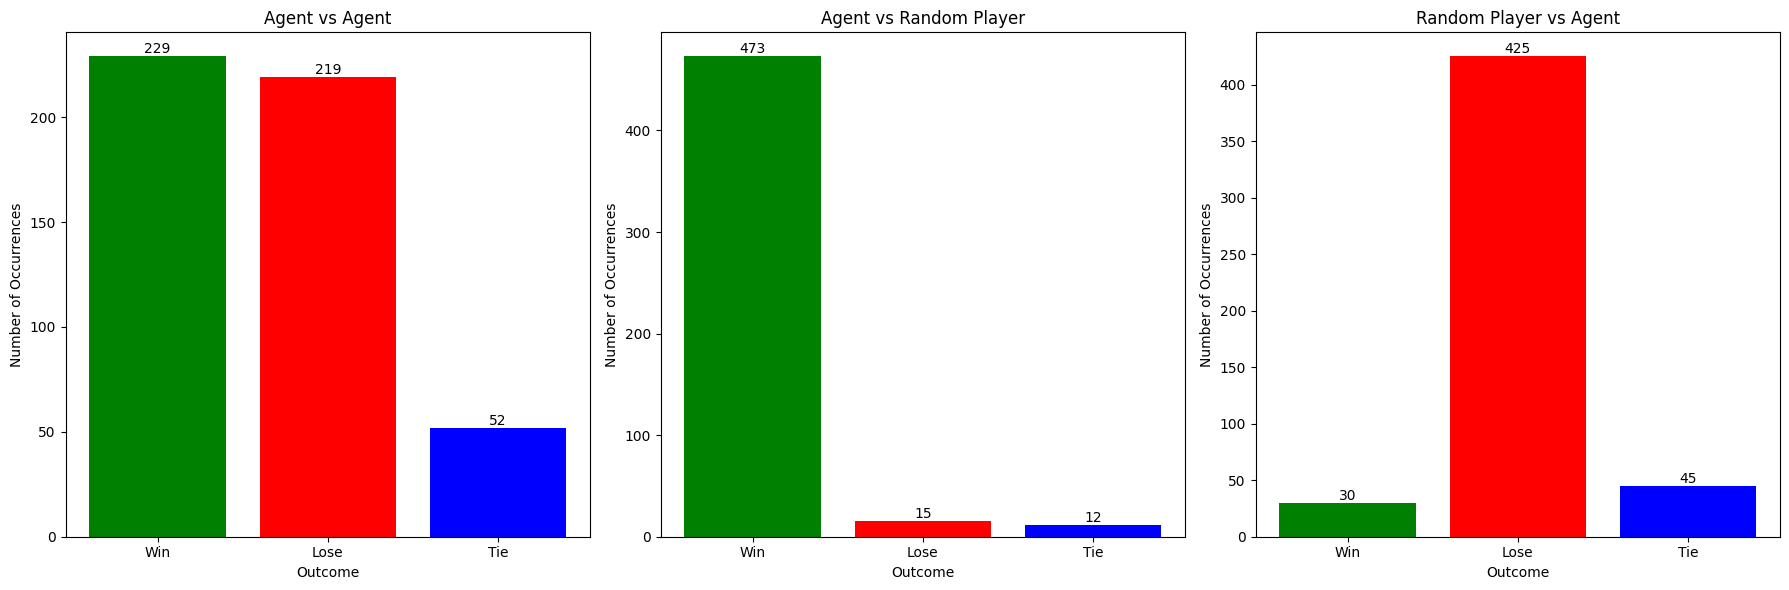

In [15]:
import matplotlib.pyplot as plt

labels = ['Win', 'Lose', 'Tie']
counts = [
    [n_win1, n_lose1, n_tie1],
    [n_win2, n_lose2, n_tie2],
    [n_win3, n_lose3, n_tie3]
]
titles = ['Agent vs Agent', 'Agent vs Random Player', 'Random Player vs Agent']
colors = ['green', 'red', 'blue']

# Create subplots: 1 row, 3 columns
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Iterate over each subplot and plot the corresponding data
for ax, count, title in zip(axs, counts, titles):
    bars = ax.bar(labels, count, color=colors)
    ax.set_title(title)
    ax.set_xlabel('Outcome')
    ax.set_ylabel('Number of Occurrences')
    
    # Annotate each bar with its height
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2.0, 
            height, 
            f'{height}', 
            ha='center', 
            va='bottom'
        )

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

In [10]:
p1 = Player("computer", exp_rate=0)
p1.loadPolicy("policy_p1")

p2 = HumanPlayer("human")

st = State(p1, p2)
st.play2()

-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
| x |   |   | 
-------------


TypeError: HumanPlayer.chooseAction() takes 2 positional arguments but 4 were given